# Monte Carlo Localization

Monte Carlo Localizationは位置推定を行う手法の1つです。
パーティクルを用いて確率分布を近似します。

注がある場合を除き、本ページに掲載されているコードはMITライセンスに、文章はクリエイティブ・コモンズ・ライセンスに基づいて公開します。

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>

## Requirements

Python 3.6以上を必要とします。

## References

https://github.com/ryuichiueda/probrobo_practice/

http://www.osaka-kyoiku.ac.jp/~challeng/SIG-Challenge-B001/SIG-Challenge-B001-4.pdf

## ヘッダファイル

数値計算及び描画に必要なモジュールおよびアニメーション作成・表示に必要なモジュールをインポートします。

In [1]:
# 数値計算及び描画に必要なモジュール
import numpy as np
import math, random
from copy import copy
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

# アニメーション作成・表示に必要なモジュール
from matplotlib import animation
from IPython.display import HTML

## 二次元のガウス分布を表現するクラス

尤度の計算と描画に使用します。

In [2]:
class Gaussian2D:
    """
    描画の際の計算や尤度の計算に使用する2次元ガウス分布
    mu_x : 中心のX座標（以下X）
    mu_y : 中心のY座標（以下Y）
    sigma_x : Xの分散
    sigma_y : Yの分散
    cov_xy : XYの共分散
    """
    def __init__(self, sigma_x = 1.0, sigma_y = 1.0, cov_xy = 0.0, mu_x = 0.0, mu_y = 0.0):
        """
        共分散行列と中心の座標を定義
        """
        self.cov = np.array([[sigma_x ** 2, cov_xy], [cov_xy, sigma_y ** 2]])
        self.mean = np.array([mu_x, mu_y])
        
    def shift(self, delta, angle):
        """
        ガウス分布の移動
        """
        # 2次元回転行列（反時計回りが正回転）
        rot2d = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
        # 共分散行列は正方行列でベクトルではないので注意
        self.cov = rot2d.T.dot(self.cov).dot(rot2d)
        self.mean = self.mean + delta
        
    def value(self, pos):
        """
        密度の算出
        """
        delta = pos - self.mean
        numerator = math.exp(-0.5 * (delta.T).dot(np.linalg.inv(self.cov)).dot(delta))
        denominator = 2 * math.pi * math.sqrt(np.linalg.det(self.cov))
        return numerator / denominator

## ランドマークを表示するためのクラス

ランドマークを配列で座標を指定します。

In [3]:
class Landmarks:
    """
    landmarks = Landmarks([[x1, y1], [x2, y2], ... , [x, y]])
    引数にランドマークのX座標とY座標を配列で指定
    """
    def __init__(self, array):
        """
        ランドマークの座標を配列で取得
        あとで計算処理しやすくするため、numpyのarrayに変換
        """
        self.positions = np.array(array)
    
    def draw(self):
        """
        取得したすべてのランドマークの座標をプロット
        """
        xs = [ e[0] for e in self.positions]
        ys = [ e[1] for e in self.positions]
        plt.scatter(xs, ys, s=300, marker='*', label='landmarks', color='orange')

## パーティクルフィルタのクラス

パーティクルフィルタのためのクラス

In [4]:
class Particle:
    """
    構造体として利用
    x : X座標
    y : Y座標
    t : 角度（方向）
    w : 重み
    """
    def __init__(self, x, y, t, w):
        self.pos = np.array([x, y, t])
        self.w = w

class ParticleFilter:
    """
    パーティクルフィルタ
    """
    def __init__(self, num):
        """
        (0, 0, 0)のパーティクルを引数で指定した個数分用意
        """
        self.particles = []
        for i in range(0, num):
            self.particles.append(Particle(0.0, 0.0, 0.0, 1.0/num))
            
    def resampling(self):
        """
        リサンプリングのためのメソッド
        重みが一部の少数のパーティクルに偏ることを防ぐために行う
        """
        # パーティクルの個数をカウント
        num = len(self.particles)
        # パーティクルの重さだけをリスト形式で抽出
        ws = [e.w for e in self.particles]
        #print(sum(ws))
        # 重みの和がゼロに丸め込まれてしまうと、サンプリングできなくなってしまう
        if sum(ws) < 1e-100:
            ws = [e + 1e-100 for e in ws]
        # パーティクルのリストからws（パーティクルの重み）に比例した確率でnum（パーティクルの個数）選ぶ
        ps = random.choices(self.particles, weights = ws, k = num)
        # 作成したリストからパーティクルを取り出して、全体の重みの合計が1になるような新しいパーティクルを作成
        self.particles = [Particle(*e.pos, 1.0/num) for e in ps]
            
    def moveParticles(self, distance, direction, robot_motion):
        """
        ロボットが動いたときにパーティクルも動かすためのメソッド
        robot_motionはロボットの移動を再現するためのもので、RobotMotionのクラスから引数で与える
        """
        self.resampling()
        for p in self.particles:
            p.pos = robot_motion(p.pos, distance, direction)
            
    def draw(self, subplot, color='blue', label='particles'):
        """
        パーティクルを描画するためのメソッド
        """
        xs = [p.pos[0] for p in self.particles]
        ys = [p.pos[1] for p in self.particles]
        vxs = [math.cos(p.pos[2]) for p in self.particles]
        vys = [math.sin(p.pos[2]) for p in self.particles]
        sub_color = color
        sub_label = label
        subplot.quiver(xs, ys, vxs, vys, color = sub_color, label = sub_label)

## ロボットとロボットのモーションのためのクラス

ロボットはロボットは現在の自身の座標を把握できないため、ロボットの描画のための座標は別のクラスで管理します。

In [5]:
class Robot:
    """
    robot = Robot(0,0,0)
    ロボットの動作を決めるためのクラス
    ロボットは現在の自身の座標を把握できません。
    そのため、描画のための座標は別のクラスで管理します。
    """
    def __init__(self, x = 0, y = 0, rad = 0):
        self.motion = RobotMotion(x, y, rad)
    
    def move(self, distance, direction):
        self.motion.updatePos(distance, direction)
        
    def draw(self, subplot, obss):
        self.motion.draw(subplot, obss)
        
    def observation(self, landmakrs):
        return self.motion.observation(landmarks)

class RobotMotion:
    """
    ロボットの描画のためのクラス
    ロボットの動作を決めるのはこのクラスではありません。
    """
    def __init__(self, x, y, theta):
        """
        ロボットの座標、角度を配列で取得、保存
        あとで計算処理しやすくするため、numpyのarrayに変換
        """
        self.actual_poses = [np.array([x, y, theta])]
        
        # パーティクルフィルタの準備
        self.pf = ParticleFilter(30)
    
    def draw(self, subplot, obss, color = 'red',label = 'actual robot motion'):
        """
        ロボットの座標、角度情報を元にベクトルを描画
        """
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        sub_color = color
        sub_label = label
        subplot.quiver(xs, ys, vxs, vys, color = sub_color, label = sub_label)
        
        for obs in obss:
            for p in self.pf.particles:
                obs.draw(subplot, p.pos)

        self.pf.draw(subplot)

    def motion(self, robot_pos, distance, direction):
        """
        ロボットを移動
        進む距離、進む角度を元に移動する先の座標をnumpyのarray形式で返す
        """
        # 移動距離に10%の標準偏差
        actual_distance = random.gauss(distance, distance * 0.1)
        # 進む角度に10%の標準偏差
        actual_direction = random.gauss(direction, direction * 0.1)
        # 移動方向に対して3[deg]の標準偏差
        dir_error = random.gauss(0.0, np.radians(3))
        px, py, pth = robot_pos
        x = px + actual_distance * math.cos(pth)
        y = py + actual_distance * math.sin(pth)
        th = pth + actual_direction + dir_error
        return np.array([x, y, th])
        
    def updatePos(self, distance, direction):
        """
        ロボットとパーティクルを移動
        進む距離、進む角度を元に位置情報を更新
        """
        self.actual_poses.append(self.motion(self.actual_poses[-1], distance, direction))
        self.pf.moveParticles(distance, direction, self.motion)
        
    def observation(self, landmarks):
        obss = []
        # すべてのランドマークについて、観測できるか確認
        for landmark in landmarks.positions:
            # ランドマークの観測結果を保存
            obs = Observation(landmark)
            obs.measure(self.actual_poses[-1])
            # センサの範囲内だったランドマークをリストに追加
            if obs.distance != None:
                obss.append(obs)

        # パーティクルの重みに尤度をかける
        for obs in obss:
            for p in self.pf.particles:
                p.w *= obs.likelihood(p.pos)

        # 観測結果をリストで返す
        return obss

In [6]:
class Observation:
    """
    ロボットの観測モデル
    """
    def __init__(self, landmark_pos, max_range = 1.0, min_range = 0.1, max_angle = (math.pi / 2), min_angle = (-math.pi / 2)):
        # ランドマークの位置を保存
        self.landmark_x, self.landmark_y = landmark_pos
        # センサの計測できる範囲を設定
        self.sensor_max_range = 1.0
        self.sensor_min_range = 0.1
        self.sensor_max_angle = math.pi / 2
        self.sensor_min_angle = - math.pi /2 
        
        # 観測できない場合のセンサ値を決めておく（ここではNone）
        # 観測できた場合はこの値を上書きする
        self.distance, self.direction, self.error_ellipse = None, None, None
        
        # センサの値を取得してセンサの観測範囲内に対象物があるかチェックする
        # 対象物があれば、&IDを保存
        #self.distance, self.direction, self.error_ellipse = self.measure(robot_pos, landmark)
        #self.lid = lid if (self.distance != None) else None 

    def measure(self, robot_pos):
        """
        センサの値を取得してセンサの観測範囲内に対象物があるかチェックする
        """
        # ロボットの位置(ロボット自身は観測不可能)を一時保存
        robot_x, robot_y, robot_th = robot_pos
        
        # センサの計測距離範囲内かどうか確認する
        distance = math.sqrt((robot_x - self.landmark_x) ** 2 + (robot_y - self.landmark_y) ** 2)
        if not distance < self.sensor_max_range and distance > self.sensor_min_range:
            self.lid = None
            return
        
        # センサの計測角度範囲内かどうか確認する
        direction = math.atan2((self.landmark_y - robot_y),(self.landmark_x - robot_x)) - robot_th
        if direction > math.pi:
            direction -= math.pi * 2
        if direction < math.pi:
            direction += math.pi * 2
        if not direction < self.sensor_max_angle and direction > self.sensor_min_angle:
            self.lid = None
            return
        
        # 真値に混入する雑音の大きさ（標準偏差）を設定
        sigma_distance = distance * 0.1           # 距離に対して10%の標準偏差
        sigma_direction = np.radians(3)    # ランドマークの方向に対して3degの標準偏差
        
        # 雑音を混ぜてセンサの値とする
        actual_distance = random.gauss(distance, sigma_distance)   
        actual_direction = random.gauss(direction, sigma_direction)
     
        # ロボット座標系での共分散行列を作っておく。あとで尤度を計算するときに使用
        # x方向が奥行きで、sigma_distanceを標準偏差に設定。y方向がロボットから見て横方向の誤差で、距離*sin(3[deg])となる。
        error_ellipse = Gaussian2D(sigma_x = sigma_distance, sigma_y = actual_distance * math.sin(sigma_direction) , cov_xy = 0.0)
        
        #return actual_distance, actual_direction, error_ellipse
        self.distance, self.direction, self.error_ellipse = actual_distance, actual_direction, error_ellipse
        
    # 尤度の計算
    # パーティクルの姿勢とランドマークの計測値からランドマークの位置を推定し、その位置に誤差楕円を置き、
    # ランドマークの真の位置が誤差楕円からどれだけ外れているかを確率密度関数の密度として返します。
    # この計算はもっと簡略化できますが、描画の関係でこういう手順を踏んでいます。
    # 簡略な方法: パーティクルの姿勢とランドマークの真の位置から、想定されるランドマークの距離・方向を算出し、
    # 実際の距離・方向とそれぞれ比較する方法。距離の誤差の傾向、方向の誤差の傾向をそれぞれ1次元のガウス分布で表現し、
    # それぞれを独立して計算して尤度を算出し、掛け算する。
    def likelihood(self,particle_pos): 
        # パーティクルの姿勢と、このインスタンスに保存されているセンサの値から、ランドマークの位置を求める
        rx, ry, rt = particle_pos
        proposed_lx = rx + self.distance * math.cos(rt + self.direction)
        proposed_ly = ry + self.distance * math.sin(rt + self.direction)
                
        # このインスタンスに保存されている共分散行列を、計算されたランドマークの位置に移し、パーティクルの向きに合わせて共分散行列を回転
        e = copy(self.error_ellipse)
        e.shift(np.array([proposed_lx, proposed_ly]).T, rt + self.direction)

        # そのままガウス分布の計算式から密度（尤度）を返します。
        return e.value(np.array([self.landmark_x,self.landmark_y]).T)
        
    
    def draw(self,subplot,robot_pos):
        rx, ry, rt = robot_pos[0], robot_pos[1], robot_pos[2]
        proposed_lx = rx + self.distance * math.cos(rt + self.direction)
        proposed_ly = ry + self.distance * math.sin(rt + self.direction)
        
        e = copy(self.error_ellipse)
        e.shift(np.array([proposed_lx, proposed_ly]).T, rt + self.direction)
        
        # 固有ベクトルを二つ求めて、それぞれの大きさを求めて楕円を作り、幅を計算した方の固有ベクトルの向きに楕円を回転すると誤差楕円になります。
        eigen = np.linalg.eig(e.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        elli = Ellipse([proposed_lx, proposed_ly],width=math.sqrt(np.linalg.norm(v1)),height=math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
        elli.set_alpha(0.2)
        
        subplot.add_artist(elli) 

In [7]:
# 新規ウィンドウと座標軸用subplotを用意
# タイトルは個別につけるので今は指定しない
fig, world = plt.subplots(figsize=(8, 8))

# ランドマークの座標を指定
landmarks = Landmarks([[-0.5, 0.0], [0.5, 0.0], [0.0, 0.5]])

# ロボットの座標を指定
robot = Robot(0,0,0)

# アニメーション作成の初期処理
# 初期処理を指定しないと、更新処理が1回分多く呼び出される
def init():
    pass

# アニメーション作成の更新処理
def update(i):
    # 座標軸用subplotの描画内容を一度クリア
    plt.cla()
    # 座標軸の範囲を指定
    world.set_xlim(-1.0,1.0)
    world.set_ylim(-0.5,1.5)
    # ランドマークを描画
    landmarks.draw()
    # ロボットを移動
    robot.move(0.2, np.radians(20))
    # 移動後の位置でランドマークを観測
    obss = robot.observation(landmarks)
    # ロボットを描画
    robot.draw(world, obss)
    # タイトルを追加
    plt.title("Robot Motion : frame{0:04d}".format(i))
    # 左上に凡例を追加
    world.legend(loc='upper left')

# アニメーションの作成
anim = animation.FuncAnimation(fig, update, init_func=init, interval=500, frames=20)

In [8]:
HTML(anim.to_html5_video())

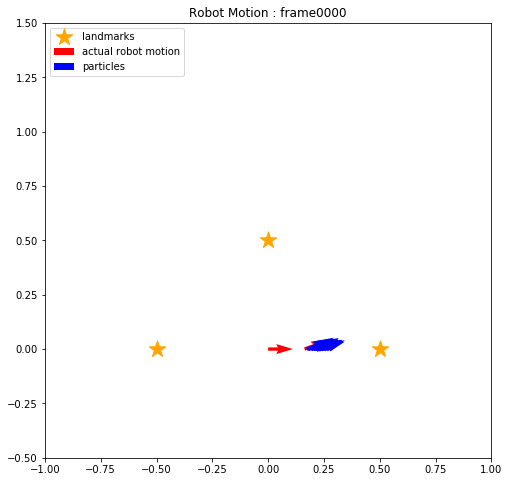

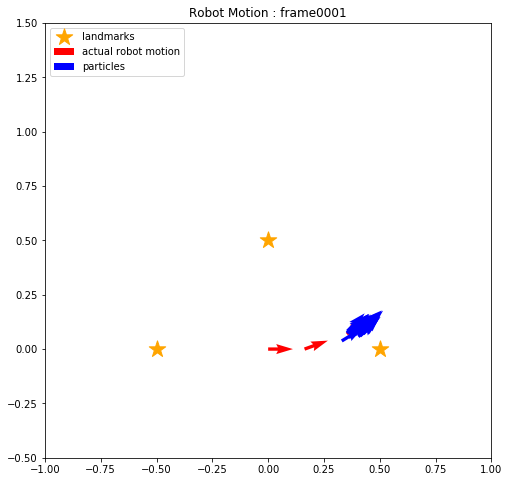

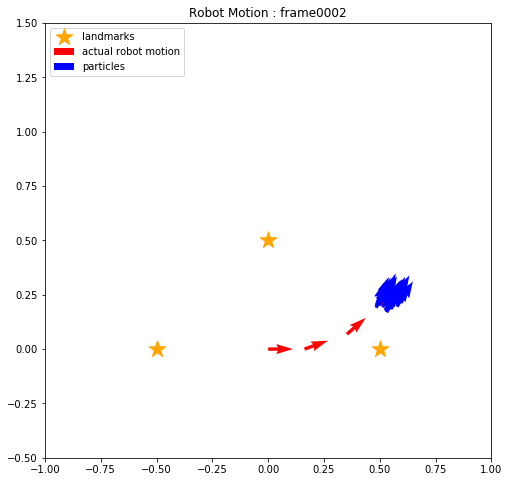

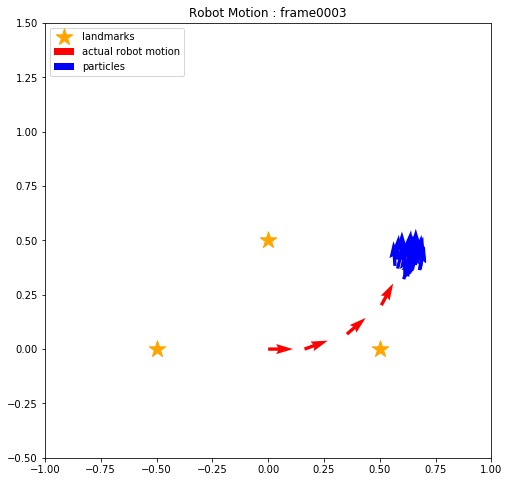

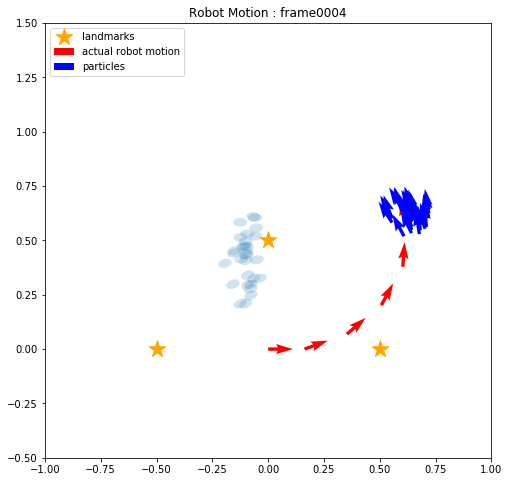

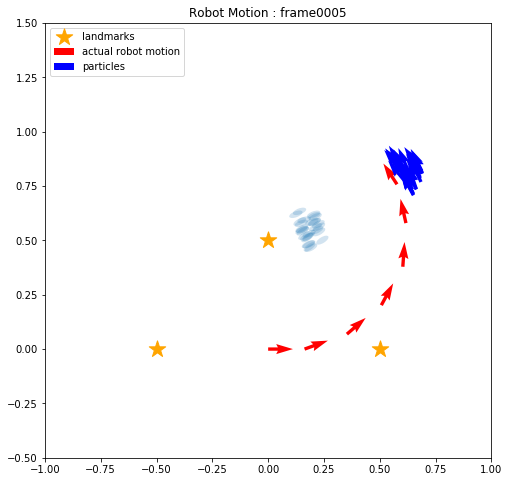

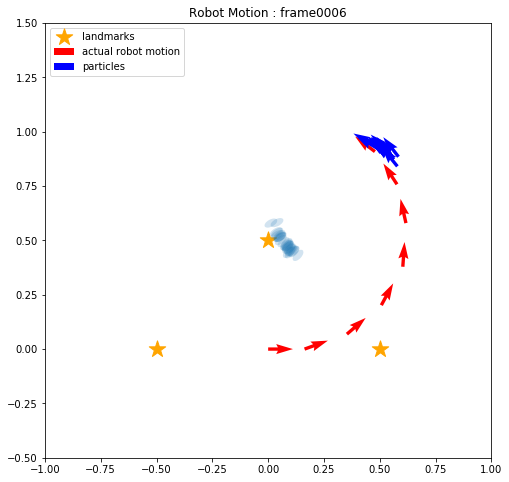

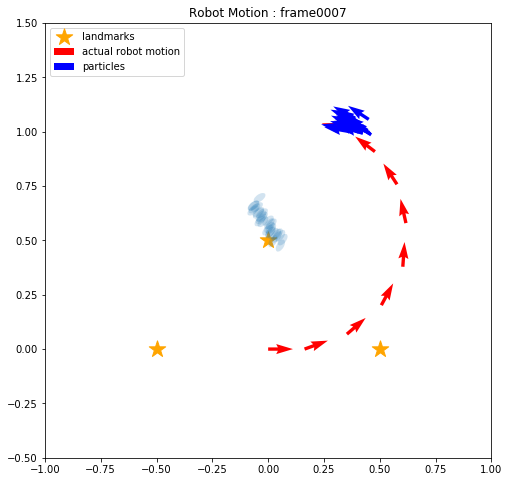

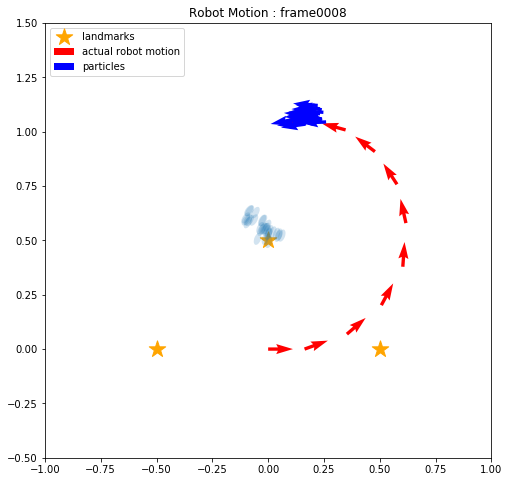

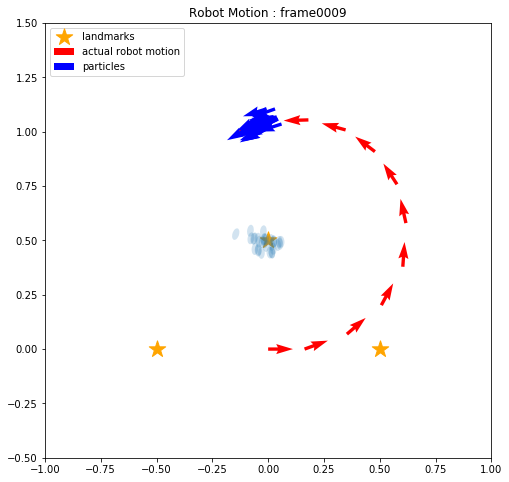

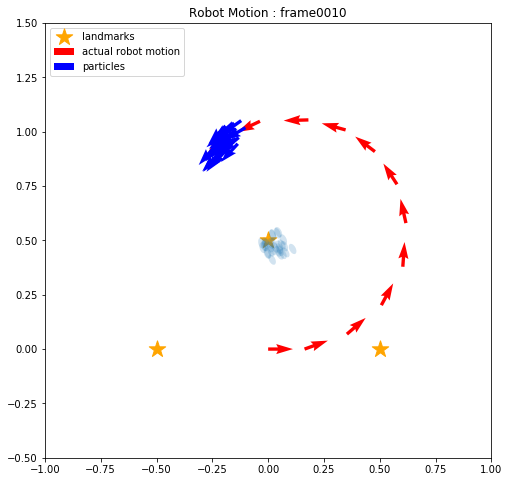

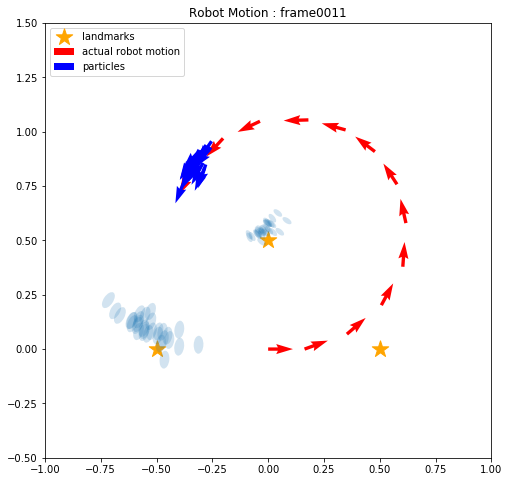

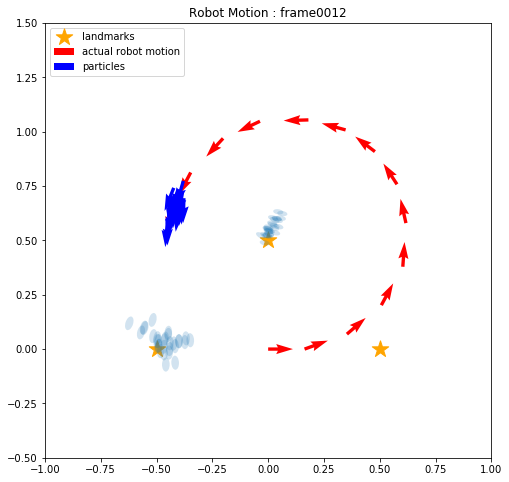

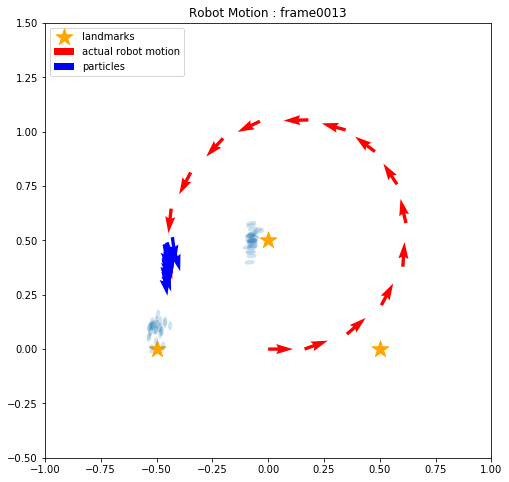

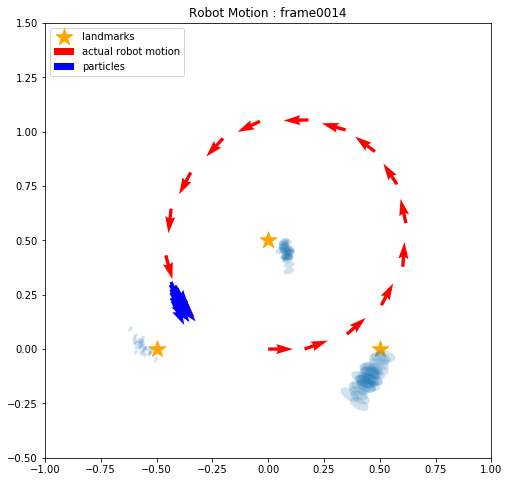

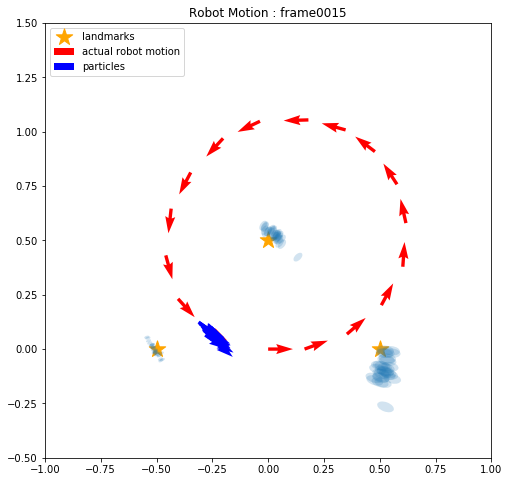

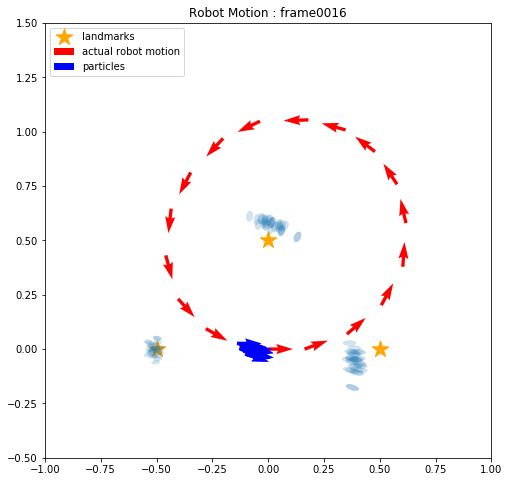

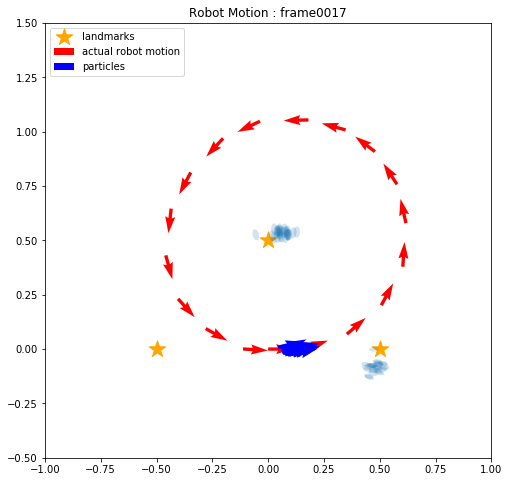

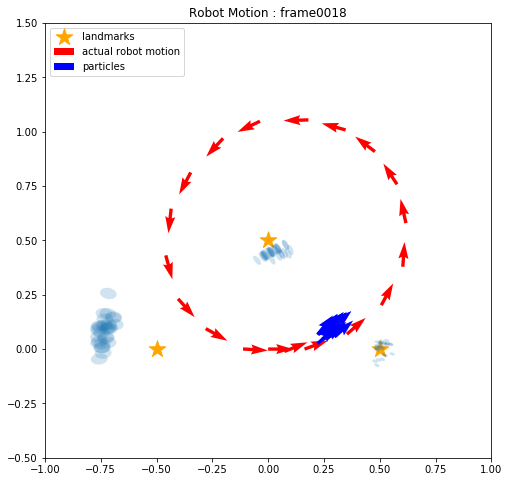

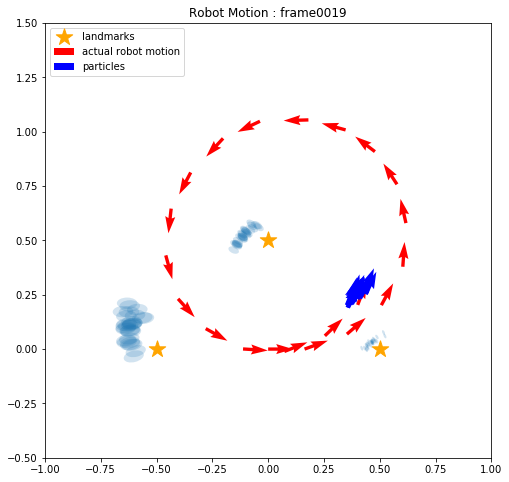

In [9]:
# figureの初期化
plt.close()

# ランドマークの座標を指定
landmarks = Landmarks([[-0.5, 0.0], [0.5, 0.0], [0.0, 0.5]])

# ロボットの座標を指定
robot = Robot(0,0,0)

# アニメーション作成の更新処理
def update(i):
    # 新規ウィンドウと座標軸を用意
    # タイトルは個別につけるので今は指定しない
    fig, world = plt.subplots(figsize=(8, 8))
    # 座標軸の範囲を指定
    world.set_xlim(-1.0,1.0)
    world.set_ylim(-0.5,1.5)
    # ランドマークを描画
    landmarks.draw()
    # ロボットを移動
    robot.move(0.2, np.radians(20))
    # ロボットを描画
    # 移動後の位置でランドマークを観測
    obss = robot.observation(landmarks)
    # ロボットを描画
    robot.draw(world, obss)
    # タイトルを追加
    plt.title("Robot Motion : frame{0:04d}".format(i))
    # 左上に凡例を追加
    world.legend(loc='upper left')

# アニメーションの作成
for i in range(0,20):
    update(i)
    plt.show()